# PDF Table to Pandas Data Frame to PDF Map

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step-1.-Install-tabula-py" data-toc-modified-id="Step-1.-Install-tabula-py-1">Step 1. Install tabula-py</a></span></li><li><span><a href="#Step-2.-Read-table-from-PDF" data-toc-modified-id="Step-2.-Read-table-from-PDF-2">Step 2. Read table from PDF</a></span></li><li><span><a href="#Step-3.-Process-the-table-contents" data-toc-modified-id="Step-3.-Process-the-table-contents-3">Step 3. Process the table contents</a></span></li><li><span><a href="#Step-4.-Merge-two-tables" data-toc-modified-id="Step-4.-Merge-two-tables-4">Step 4. Merge two tables</a></span></li><li><span><a href="#Step-5.-Draw-the-top-20-impacted-counties" data-toc-modified-id="Step-5.-Draw-the-top-20-impacted-counties-5">Step 5. Draw the top 20 impacted counties</a></span></li><li><span><a href="#Step-6.-Export-to-PDF" data-toc-modified-id="Step-6.-Export-to-PDF-6">Step 6. Export to PDF</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7">References</a></span></li></ul></div>

Often PDF files can contain useful information presented in a tabular form. If such data contains location information, it would be much more insightful if presented as a cartographic map. Thus this sample shows how Pandas can be used to extract data from a table within a PDF file (in this case, a PDF accessible from `California Department of Forestry & Fire Protection (CAL FIRE)` website) and how it can be then brought into the GIS for further analysis and visualization.

## Step 1. Install tabula-py

**Note**: to run this sample, you need a few extra libraries in your conda environment. If you don't have the libraries, install them by running the following commands from cmd.exe or your shell

```
pip install lxml
pip install html5lib
pip install tabula-py==1.4.3
```

<a href="https://pypi.org/project/tabula-py/">`tabula-py`</a> can read table of PDF and convert into panda's `DataFrame`. In order to have tabula-py work on your environment, please make sure you have Java 7 or 8 on your machine before installing <a href="https://github.com/chezou/tabula-py">tabula-py</a>. 

In [1]:
import pandas as pd
import numpy as np
import requests

## Step 2. Read table from PDF

**California Department of Forestry & Fire Protection (CAL FIRE)** provides statistics and reports that are tracked on a weekly basis and also snapshots of the number of fires and acres burned. These are preliminary numbers taken from the Computer Aided Dispatch system, and will likely change as dispatched wildfires may end up being other types of fires or false alarms <a href="#References"> [1]</a>.

The table of **Number of Fires and Acres** can be fetched from the web page and parsed as a Pandas data frame (as following):

In [2]:
url = requests.get("https://www.fire.ca.gov/our-impact/statistics/")
df = pd.read_html(url.text)[1]
df.head()

,INTERVAL,WILDLAND FIRES,ACRES
0,2023 Combined YTD (CALFIRE & US Forest Service),340,110
1,2022 Combined YTD (CALFIRE & US Forest Service),1210,6195
2,5-Year Average (same interval),842,2563


Also **CAL FIRE** provides statistically summarizing reports for historic wildfires in California, e.g. **Top 20 largest**, **Top 20 most destructive**, and **top 20 deadliest**, URLs of which are kept in a list below:

In [3]:
pdf_url_list = ["https://34c031f8-c9fd-4018-8c5a-4159cdff6b0d-cdn-endpoint.azureedge.net/-/media/calfire-website/our-impact/fire-statistics/featured-items/top20_acres.pdf",
                "https://34c031f8-c9fd-4018-8c5a-4159cdff6b0d-cdn-endpoint.azureedge.net/-/media/calfire-website/our-impact/fire-statistics/featured-items/top20_destruction.pdf",
                "https://34c031f8-c9fd-4018-8c5a-4159cdff6b0d-cdn-endpoint.azureedge.net/-/media/calfire-website/our-impact/fire-statistics/featured-items/top20_deadliest.pdf"]

Provided the url of the online PDF file, `tabula-py` can read the table from the pdf at the url.

If you run into an error with tabula and wrapper please refer to this [helpful guide](https://tabula-py.readthedocs.io/en/latest/getting_started.html#get-tabula-py-working-windows-10)

In [6]:
from tabula import wrapper
df = wrapper.read_pdf(pdf_url_list[0])

Alternatively, we can also download the online PDF file, and parse locally, such as:
```
import tabula
from urllib.request import Request, urlopen

f = open('./top20_acres.pdf', 'wb')
url_request = Request(pdf_url_list[0], 
                      headers={"User-Agent": "Mozilla/5.0"})
webpage = urlopen(url_request).read()
f.write(webpage)
f.close()

#################################################

df = tabula.read_pdf('top20_acres.pdf', stream=False, pages = "all", multiple_tables = True)
```

In [7]:
# in order to print first 5 lines of Table
df.head()

,FIRE NAME (CAUSE),DATE,COUNTY,ACRES,STRUCTURES,DEATHS
0,1\rAUGUST COMPLEX (Lightning),August 2020,"Mendocino, Humboldt, Trinity,\rTehama, Glenn, ...","1,032,648",935,1.0
1,2 DIXIE (Powerlines),July 2021,"Butte, Plumas, Lassen, Shasta & Tehama","963,309","1,311",1.0
2,3MENDOCINO COMPLEX\r(Human Related),July 2018,"Colusa, Lake, Mendocino & Glenn","459,123",280,1.0
3,4SCU LIGHTNING COMPLEX\r(Lightning),August 2020,"Stanislaus, Santa Clara, Alameda, Contra\rCost...","396,625",225,0.0
4,5\rCREEK (Undetermined),September 2020,Fresno & Madera,"379,895",858,0.0


## Step 3. Process the table contents

Looking at each columns presented in the Pandas data frame, some are having composite information and would require further processing. For example, `FIRE NAME (CAUSE)` column contains a sequential ordering number, fire name, and cause in one string, and would need to be split into separate columns.

Next, break the `FIRE NAME (CAUSE)` column into `ID`, `Fire Name` and `Cause` columns:

In [8]:
# new data frame with split value columns 
new = df["FIRE NAME (CAUSE)"].str.split("(", n = 1, expand = True) 
  
df["ID"] = new[0].str[0]

# making separate first name column from new data frame 
df["FIRE NAME"]= new[0].str.replace('\r', '').str[1:]

# making separate last name column from new data frame 
df["CAUSE"]= new[1].str[:-1]

df = df.drop(["FIRE NAME (CAUSE)"], axis=1)

df.drop(df.tail(1).index,inplace=True)

In [9]:
df.head()

,DATE,COUNTY,ACRES,STRUCTURES,DEATHS,ID,FIRE NAME,CAUSE
0,August 2020,"Mendocino, Humboldt, Trinity,\rTehama, Glenn, ...","1,032,648",935,1.0,1,AUGUST COMPLEX,Lightning
1,July 2021,"Butte, Plumas, Lassen, Shasta & Tehama","963,309","1,311",1.0,2,DIXIE,Powerlines
2,July 2018,"Colusa, Lake, Mendocino & Glenn","459,123",280,1.0,3,MENDOCINO COMPLEX,Human Related
3,August 2020,"Stanislaus, Santa Clara, Alameda, Contra\rCost...","396,625",225,0.0,4,SCU LIGHTNING COMPLEX,Lightning
4,September 2020,Fresno & Madera,"379,895",858,0.0,5,CREEK,Undetermined


Similar to `FIRE NAME (CAUSE)` column, the `ACRES` column also has composite information for some rows. For instance, when the fire happens in two states, e.g. CA and NV, you would see in the `ACRES` column - `271,911 CA /\r43,666 NV  `, the actual impacted area is the sum of 271911 and 43666 acres, and some numeric extraction and summing need to be done here:

In [10]:
import re

"""Used to extract numbers from composite string e.g. "271,911 CA /\r43,666 NV" 
   and add the acres within two or more states
"""
def extract_and_sum(s):
    tmp = map(int, re.sub(r'[ a-zA-Z,]+[ a-zA-Z,]+', '', s, re.I).replace(',','').split('/\r'))
    return sum(list(tmp))

"""Used to turn numerics e.g. 273,911 to int without delimitors e.g. 273911
"""
def replace_and_reassign(s):
    return int(s.replace(',',''))

temp= df['ACRES'].apply(lambda x: extract_and_sum(x) if '\r' in x else replace_and_reassign(x))

In [11]:
df['ACRES'] = temp
df.head()

,DATE,COUNTY,ACRES,STRUCTURES,DEATHS,ID,FIRE NAME,CAUSE
0,August 2020,"Mendocino, Humboldt, Trinity,\rTehama, Glenn, ...",1032648,935,1.0,1,AUGUST COMPLEX,Lightning
1,July 2021,"Butte, Plumas, Lassen, Shasta & Tehama",963309,"1,311",1.0,2,DIXIE,Powerlines
2,July 2018,"Colusa, Lake, Mendocino & Glenn",459123,280,1.0,3,MENDOCINO COMPLEX,Human Related
3,August 2020,"Stanislaus, Santa Clara, Alameda, Contra\rCost...",396625,225,0.0,4,SCU LIGHTNING COMPLEX,Lightning
4,September 2020,Fresno & Madera,379895,858,0.0,5,CREEK,Undetermined


Now we have cleaned up the `FIRE NAME (CAUSE)` and the `ACRES` columns, the last column that needs splitting is `COUNTY` which contains multiple impacted counties in California when the fire happens to multiple counties. Here, we will need to split a row of N counties to N rows with 1 county each.

Since the delimiter can be `,` or `&`, we would need to do `explode_str` twice (then remove `\r` and `County` from the column):

In [12]:
"""Using `numpy.arrange` in creating new rows as place holder to hold the splitted strings from df[col] based on `sep`;
   then `iloc` and `assign` to place the splitted results into newly added rows
"""
def explode_str(df, col, sep):
    s = df[col]
    i = np.arange(len(s)).repeat(s.str.count(sep) + 1)
    return df.iloc[i].assign(**{col: sep.join(s).split(sep)})

new_df = explode_str(df, 'COUNTY', ',')

In [13]:
new_df = explode_str(new_df, 'COUNTY', '&')

In [14]:
new_df['COUNTY'] = new_df['COUNTY'].str.replace('\r','')

In [15]:
new_df['NAME'] = new_df['COUNTY'].str.replace(' County','')

To reduce ambiguity, we are adding an additional column `STATE` to the DataFrame, so two counties with the same name (but in different states) will be cause confusions.

In [16]:
new_df['STATE'] = 'CA'

In [17]:
new_df.head()

,DATE,COUNTY,ACRES,STRUCTURES,DEATHS,ID,FIRE NAME,CAUSE,NAME,STATE
0,August 2020,Mendocino,1032648,935,1.0,1,AUGUST COMPLEX,Lightning,Mendocino,CA
0,August 2020,Humboldt,1032648,935,1.0,1,AUGUST COMPLEX,Lightning,Humboldt,CA
0,August 2020,Trinity,1032648,935,1.0,1,AUGUST COMPLEX,Lightning,Trinity,CA
0,August 2020,Tehama,1032648,935,1.0,1,AUGUST COMPLEX,Lightning,Tehama,CA
0,August 2020,Glenn,1032648,935,1.0,1,AUGUST COMPLEX,Lightning,Glenn,CA


## Step 4. Merge two tables

The DataFrame we have got so far contains fire statistics, and would need to be aggregated with shape or geometry data in order to be drawn or saved as Web Map item. In doing such, we will access an existing feature layer called `USA Counties`, and merge the geographic attributes of each counties in this feature layer (e.g. 'Shape_Area', 'Shape_Leng', 'Shape__Area', 'Shape__Length') into the fire statistics table.

Before we can access the Feature Layer, let us connect to our GIS to geocode this data and present it as a map, either by specifying username and password, e.g. in `gis = GIS("https://www.arcgis.com", "your username", "your password")` or via an existing profile:

In [26]:
from arcgis.gis import GIS

gis = GIS('home')

<Item title:"USA Counties" type:Feature Layer Collection owner:esri_dm>
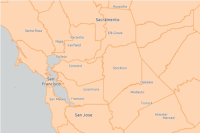

In [27]:
counties_item = gis.content.get('48f9af87daa241c4b267c5931ad3b226')
counties_item

In [28]:
counties_flayer = counties_item.layers[0]
counties_fset = counties_flayer.query("STATE_NAME='California'")
counties_fset.sdf['NAME'].head()

0      Alameda County
1       Alpine County
2       Amador County
3        Butte County
4    Calaveras County
Name: NAME, dtype: string

In [29]:
counties_fset.sdf.columns

Index(['FID', 'NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS', 'FIPS',
       'POPULATION', 'POP_SQMI', 'POP2010', 'POP10_SQMI', 'WHITE', 'BLACK',
       'AMERI_ES', 'ASIAN', 'HAWN_PI', 'HISPANIC', 'OTHER', 'MULT_RACE',
       'MALES', 'FEMALES', 'AGE_UNDER5', 'AGE_5_9', 'AGE_10_14', 'AGE_15_19',
       'AGE_20_24', 'AGE_25_34', 'AGE_35_44', 'AGE_45_54', 'AGE_55_64',
       'AGE_65_74', 'AGE_75_84', 'AGE_85_UP', 'MED_AGE', 'MED_AGE_M',
       'MED_AGE_F', 'HOUSEHOLDS', 'AVE_HH_SZ', 'HSEHLD_1_M', 'HSEHLD_1_F',
       'MARHH_CHD', 'MARHH_NO_C', 'MHH_CHILD', 'FHH_CHILD', 'FAMILIES',
       'AVE_FAM_SZ', 'HSE_UNITS', 'VACANT', 'OWNER_OCC', 'RENTER_OCC',
       'NO_FARMS12', 'AVE_SIZE12', 'CROP_ACR12', 'AVE_SALE12', 'SQMI',
       'NO_FARMS17', 'AVE_SIZE17', 'CROP_ACR17', 'AVE_SALE17', 'Shape_Leng',
       'Shape_Area', 'Shape__Area', 'Shape__Length', 'SHAPE'],
      dtype='object')

In [37]:
county_df = counties_fset.sdf

# new data frame with split value columns
county_name = county_df["NAME"].str.split(" ", n = 1, expand = True)
 
# making separate first name column from new data frame
county_df["NAME"]= county_name[0]
 
# Dropping old Name columns
#counties_fset.sdf.drop(columns =["NAME"], inplace = True)

In [38]:
county_df['NAME'].head()

0      Alameda
1       Alpine
2       Amador
3        Butte
4    Calaveras
Name: NAME, dtype: string

In [39]:
cols_2 = ['NAME', 'POPULATION', 'POP_SQMI',
          'SHAPE', 'SQMI', 'STATE_FIPS', 'STATE_NAME', 'Shape_Area',
          'Shape_Leng', 'Shape__Area', 'Shape__Length']
overlap_rows = pd.merge(left = county_df[cols_2], right = new_df, how='inner',
                        on = 'NAME')
overlap_rows.head()

,NAME,POPULATION,POP_SQMI,SHAPE,SQMI,STATE_FIPS,STATE_NAME,Shape_Area,Shape_Leng,Shape__Area,Shape__Length,DATE,COUNTY,ACRES,STRUCTURES,DEATHS,ID,FIRE NAME,CAUSE,STATE
0,Alpine,1109,1.5,"{""rings"": [[[-13347274.7354533, 4711759.132550...",743.19,06,California,0.199044,2.174211,3156006463.34766,275565.132608,August 2021,Alpine,221835,"1,005",1.0,1,5CALDOR,Human Releated,CA
1,Butte,210520,125.5,"{""rings"": [[[-13514702.0771214, 4887275.447179...",1677.13,06,California,0.455942,4.205812,7340032590.01172,525974.550226,July 2021,Butte,963309,"1,311",1.0,2,DIXIE,Powerlines,CA
2,Butte,210520,125.5,"{""rings"": [[[-13514702.0771214, 4887275.447179...",1677.13,06,California,0.455942,4.205812,7340032590.01172,525974.550226,August 2020,Butte,318935,"2,352",15.0,7,NORTH COMPLEX,Lightning,CA
3,Colusa,22365,19.3,"{""rings"": [[[-13592839.1212537, 4781210.042935...",1156.36,06,California,0.312199,3.21312,4990775494.50781,386041.097903,July 2018,Colusa,459123,280,1.0,3,MENDOCINO COMPLEX,Human Related,CA
4,Lassen,32159,6.8,"{""rings"": [[[-13493147.7427554, 5039582.826952...",4720.12,06,California,1.302088,5.973928,21275574862.617199,776771.27369,August 2012,Lassen,315577,0,0.0,1,0RUSH,Lightning,CA


## Step 5. Draw the top 20 impacted counties

We now can draw the top 20 impacted counties, represented by the merged output DataFrame `overlap_rows`, with the API method `DataFrame.spatial.plot()`.


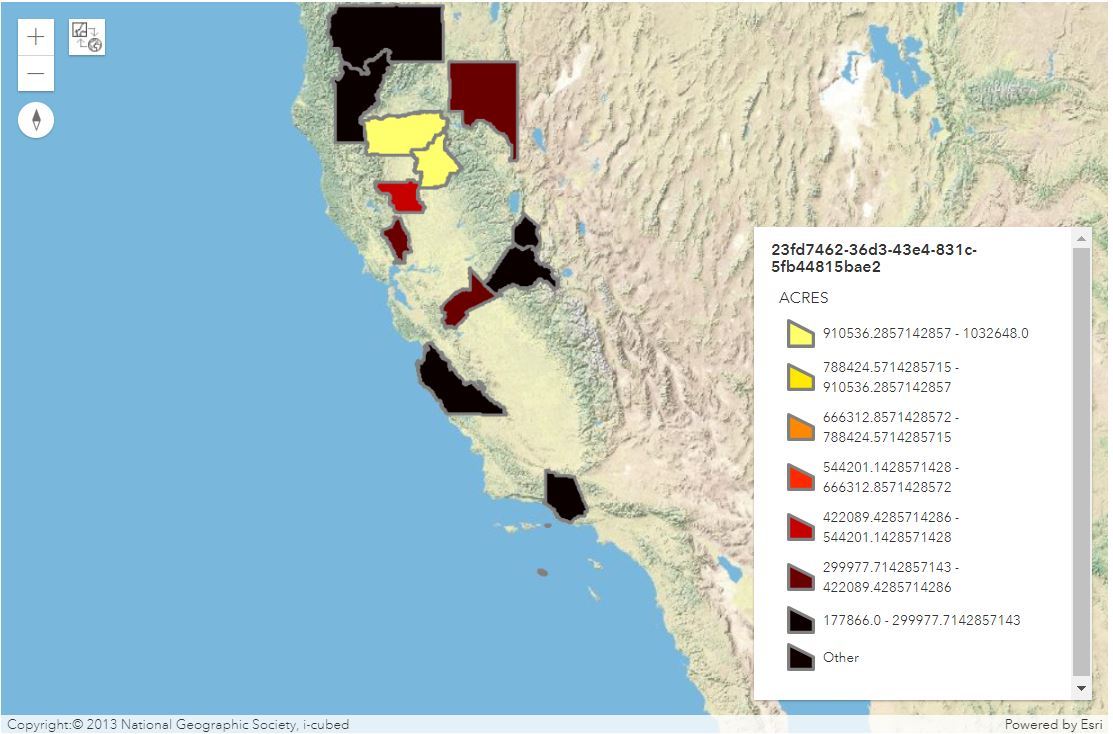

In [44]:
map1 = gis.map('California, USA')
map1.layout.height = '650px'
map1.legend = True
map1

In [41]:
map1.clear_graphics()
overlap_rows.spatial.plot(kind='map', map_widget=map1,
                          renderer_type='c',  # for class breaks renderer
                          method='esriClassifyNaturalBreaks',  # classification algorithm
                          class_count=7,  # choose the number of classes
                          col='ACRES',  # numeric column to classify
                          cmap='hot',  # color map to pick colors from for each class
                          alpha=0.7  # specify opacity
                         )

True

Besides viewing the top 20 impacted counties in the notebook's map widget, we can also save it as a web map, or then export the web map to a PDF output again.

In [42]:
item_properties = {
    "title": "Top 20 largest Wildfires in California Till April 2023",
    "tags" : "wildfire",
    "snippet": "read pdf and export pdf",
    "description": "test description"
}
item = map1.save(item_properties)
item

<Item title:"Top 20 largest Wildfires in California Till April 2023" type:Web Map owner:arcgis_python>

## Step 6. Export to PDF

If you would also like to export the fire impacting counties into a PDF map, the required steps are: (1) obtain the web map json via the `Item.get_data()` API method, (2) modify the web map json to also include `exportOptions` and `mapOptions`, and (3) use `arcgis.mapping.export_map()` to get the PDF deliverable of the web map.

In [25]:
webmap_json = item.get_data()
webmap_json.keys()

dict_keys(['operationalLayers', 'baseMap', 'spatialReference', 'version', 'authoringApp', 'authoringAppVersion'])

In [26]:
map1.extent

{'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': -14383204.412078053,
 'ymin': 3664734.601863475,
 'xmax': -11976355.265435062,
 'ymax': 5254624.790194718}

Based on <a href="https://enterprise.arcgis.com/en/server/latest/create-web-apps/windows/exportwebmap-specification.htm">webmap spec</a>, the `mapOptions` and `exportOptions` also need to be specified for the json input. Here, the `extent` and `scale` are chosen based on the extents of the California State <a href="#References">[2]</a>.

In [27]:
webmap_json['mapOptions'] = {
    "extent" : {
        "xmin": -14383204.412078043,
        "ymin": 3664734.6018634685,
        "xmax": -11976355.2654350533,
        "ymax": 5254624.790194712,
        "spatialReference": {
            "latestWkid": 3857,
            "wkid": 102100
        }
    },
    "scale" : 9244648.868618,
    "spatialReference" : {
        "wkid" : 102100
    }
}

In [28]:
webmap_json['exportOptions'] = { "dpi" : 96,
                                 "outputSize" :  [746, 575]
                               }

Finally, we used <a href="https://developers.arcgis.com/python/api-reference/arcgis.mapping.toc.html?highlight=export#arcgis.mapping.export_map">`export_map`</a> method to create a PDF output of the web map item <a href="#References">[3]</a>.

In [29]:
from arcgis.mapping import export_map
res = export_map(web_map_as_json=webmap_json, format='PDF', layout_template='MAP_ONLY')
#res["url"]
res.url

'https://utility.arcgisonline.com/arcgis/rest/directories/arcgisoutput/Utilities/PrintingTools_GPServer/x_____xl3SfXO9Y8JofGGdEpHmfWw..x_____x_ags_7bdbaffa-e78b-11ea-96b8-22000bb3a270.pdf'

The `res.url` shown above points to the URL address of the exported map which displays the top 20 most impacted counties in California by wildfire. If interested in creating more fun maps from the PDF files provided by **CAL FIRE**, you can repeat the previously done workflow with two other links stored in variable `pdf_url_list`.

## References

[1] https://www.fire.ca.gov/stats-events/

[2] https://enterprise.arcgis.com/en/server/latest/create-web-apps/windows/exportwebmap-specification.htm

[3] https://developers.arcgis.com/python/api-reference/arcgis.mapping.toc.html?highlight=export#arcgis.mapping.export_map